## Text Classification with BERT

This notebook contains complete code to fine-tune BERT to perform text classification.

**Outline:**

- Load the dataset
- Load a BERT model from TensorFlow Hub
- Build a model by combining BERT with a classifier
- Train the model, fine-tuning BERT as part of that
- Save the model to deploy

## Setup




In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 7.8MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 849kB 7.3MB/s 
     |████████████████████████████████| 1.1MB 17.3MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 174kB 36.9MB/s 
     |████████████████████████████████| 36.7MB 89kB/s 
     |████████████████████████████████| 358kB 45.7MB/s 


### Import Packages

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  

import matplotlib.pyplot as plt

### Load and Preprocess the Data

Next, we will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/dataset',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/dataset',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 38018 files belonging to 4 classes.
Using 30415 files for training.
Found 38018 files belonging to 4 classes.
Using 7603 files for validation.


Let's take a look at a few examples.

In [ ]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Text: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

## Loading models from TensorFlow Hub

Here we can choose which BERT model we will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.
- [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/albert_en_preprocess/2'

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/albert_en_base/2'

### Model Development

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = 'acc'

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

### Model Training

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/5
951/951 [==============================] - 648s 669ms/step - loss: 0.7918 - acc: 0.6887 - val_loss: 0.3375 - val_acc: 0.8881
Epoch 2/5
951/951 [==============================] - 628s 661ms/step - loss: 0.2814 - acc: 0.9059 - val_loss: 0.2882 - val_acc: 0.9082
Epoch 3/5
951/951 [==============================] - 628s 661ms/step - loss: 0.1805 - acc: 0.9427 - val_loss: 0.3166 - val_acc: 0.9152
Epoch 4/5
951/951 [==============================] - 628s 661ms/step - loss: 0.1145 - acc: 0.9633 - val_loss: 0.3758 - val_acc: 0.9179
Epoch 5/5
951/951 [==============================] - 628s 661ms/step - loss: 0.0630 - acc: 0.9817 - val_loss: 0.4001 - val_acc: 0.9242


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


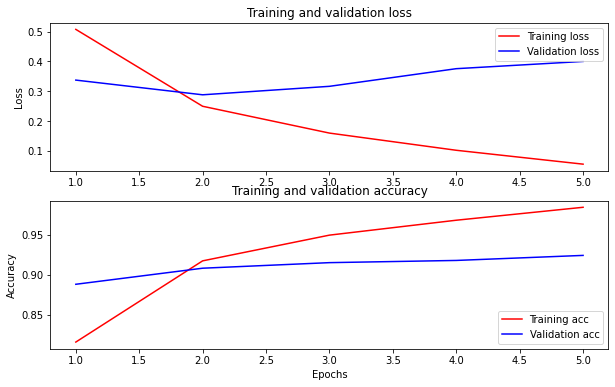

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Export for inference

Now we just save our fine-tuned model for later use.

In [ ]:
saved_model_path = 'bert_saved_model'
classifier_model.save(saved_model_path, include_optimizer=False)